In [540]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [541]:
import numpy as np
import pandas as pd
import datetime as dt 
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [542]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [543]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [544]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [545]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [546]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [547]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [557]:

# Find the most recent date in the data set.
session.query(measurement.date).\
        order_by(measurement.date.desc()).\
        first()


('2017-08-23',)

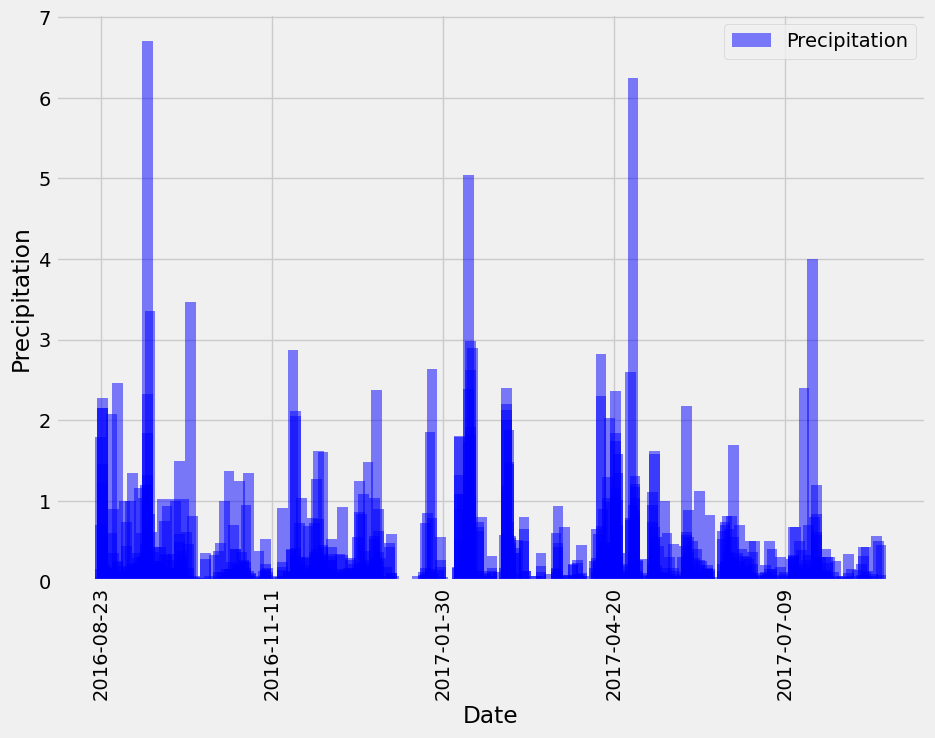

In [549]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_tuple=session.\
        query(measurement.date).\
        order_by(measurement.date.desc()).\
        first()

most_recent_dt = datetime.strptime(most_recent_date_tuple[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
prev_year_dt = dt.date(most_recent_dt.year - 1, most_recent_dt.month, most_recent_dt.day)

# Perform a query to retrieve the data and precipitation scores
#start_
sel = [measurement.date, measurement.prcp]

precip_data = session.query(*sel).\
        filter(measurement.date >= prev_year_dt).\
        all()
precip_data

precip_df=pd.DataFrame(precip_data,columns=['Date',"Precipitation"])
precip_df = precip_df.dropna(how='any') # clean up non value entries

# Sort the dataframe by date
precip_df=precip_df.sort_values(["Date"], ascending=True)
precip_df=precip_df.set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data
xx = precip_df.index.tolist()
yy = precip_df['Precipitation'].tolist()
plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')
plt.xticks(major_ticks)
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()

In [550]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [551]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.name.distinct()).count() 

9

In [552]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel=[measurement.station,func.count(measurement.date)]
station_activity = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.date).desc()).all()
station_activity  

   

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [553]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#'USC00519281', 2772
sel=[func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
most_actv_lha = session.query(*sel).\
                        filter(measurement.station == station_activity[0][0]).all()
most_actv_lha

#USC00519281_temp                       

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

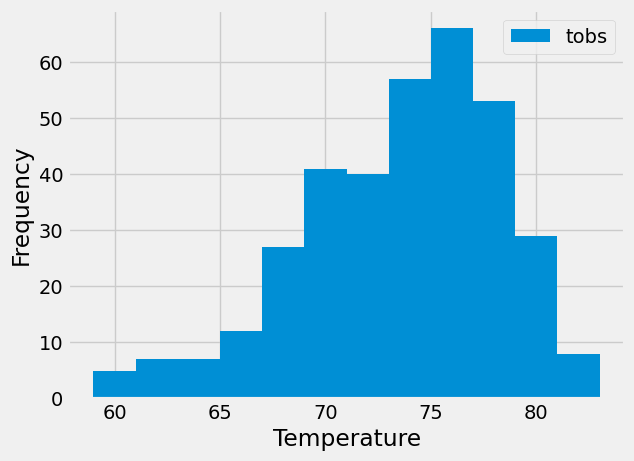

In [554]:

most_actv_stat_data = session.query(measurement.date, measurement.tobs).\
                        filter(measurement.station == station_activity[0][0]).\
                        filter(measurement.date >= prev_year_dt).all()

# convert to dataframe
most_actv_stat_df = pd.DataFrame(most_actv_stat_data)

# historgram
ax=most_actv_stat_df.plot.hist(bins=12)
ax.set_xlabel('Temperature')

In [555]:
USC00519281_temp_freq_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


# Close Session

In [556]:
# Close Session
session.close()